# Plot actionmeasure
In this notebook, the $\textbf{action measure}$ over time is calculated for a certain region. The $\textbf{action measure}$ is defined which is the integral of exceedance (Tmax from 90th percentile) over the duration of three or more consecutive days. This is further explained in 'Statistical Analysis of Climate Extremes' by Manfred Mudelsee.

Daily data is used from CMIP6 as input, using dowloaded data from ESGF and CEDA or on the Jasmin server. Esgf data can be downloaded from here: https://esgf-node.llnl.gov/search/esgf-llnl/.

- First detrend the data using seasonal decomposition or fast fourier transform. 
- Then the 90th percentile is calculated.
- Then the integral of exceedance of the 90th percentile is calculated when an extreme event lasts for three or more days
- The ouput is a new netcdf datafile which includes the action measure instead of the data variable.

In [13]:
from netCDF4 import Dataset
import cartopy
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xarray as xr
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import integrate
import scipy

# find daily dataset
### what datasets are being used

daily_tas_hist = '/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/historical/r1i1p1f2/day/tas/gn/latest/tas_day_UKESM1-0-LL_historical_r1i1p1f2_gn_19500101-20141230.nc'
daily_tas_fut1 = '/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp585/r1i1p1f2/day/tas/gn/latest/tas_day_UKESM1-0-LL_ssp585_r1i1p1f2_gn_20150101-20491230.nc'
daily_tas_fut2 = '/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp585/r1i1p1f2/day/tas/gn/latest/tas_day_UKESM1-0-LL_ssp585_r1i1p1f2_gn_20500101-21001230.nc'

In [14]:
tas_daily_hist_fut_bang = xr.open_dataset('data/daily_tas_merged.nc')

## file for whole world
#tas_asia_LL_UKES = xr.open_dataset('asia_UKESLL.nc')
#asia_LL_UKES = xr.open_dataset('asia_UKESLL.nc')
gvd = xr.open_dataset('asia_UKES_LL.nc')

In [23]:
had_HM_hist 

<xarray.Dataset>
Dimensions:    (time: 23400, bnds: 2, lon: 1024, lat: 768)
Coordinates:
  * time       (time) object 1950-01-01 12:00:00 ... 2014-12-30 12:00:00
  * lon        (lon) float64 0.1758 0.5273 0.8789 1.23 ... 359.1 359.5 359.8
  * lat        (lat) float64 -89.88 -89.65 -89.41 -89.18 ... 89.41 89.65 89.88
    height     float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lon_bnds   (lon, bnds) float64 ...
    lat_bnds   (lat, bnds) float64 ...
    tas        (time, lat, lon) float32 ...
Attributes: (12/54)
    CDI:                     Climate Data Interface version 2.0.5 (https://mp...
    source:                  HadGEM3-GC31-HM (2016): \naerosol: UKCA-GLOMAP-m...
    institution:             Met Office Hadley Centre, Fitzroy Road, Exeter, ...
    Conventions:             CF-1.7 CMIP-6.0
    activity_id:             HighResMIP
    branch_method:           fixed historical forcing from 1950 was applied f...
    ...                      ...
    branch_time_in_parent:   10800.0
    branch_time_in_child:    0.0
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.MOHC.HadGEM...
    data_specs_version:      01.00.23
    history:                 Wed Jun 22 10:29:46 2022: cdo mergetime tas_day_...
    CDO:                     Climate Data Operators version 2.0.5 (https://mp...

In [15]:
had_HM_hist = xr.open_dataset('data/hadm_HM_hist.nc')

In [16]:
had_HM_fut = xr.open_dataset('data/hadm_HM_fut.nc')

In [17]:
def calculate_action_measure_list(daily_NT, p):
    action_measure_list = [0,0]
    included_days = []

    for i in range(2, len(daily_NT.values)):
        if i in included_days:
            continue
        else:
            temperature_day = daily_NT.values[i]
            if temperature_day > p:
                # find duration of event
                j = i - 2
                duration_count = 0
                while daily_NT.values[j] > p:
                    j += 1
                    duration_count += 1
                # if event lasts for 3 days or more, we'll find the action measure
                if duration_count  >= 3:
                    # slice data and calculate how much it exceeds threshold
                    exceedances = [k - p for k in daily_NT.data[(i-2):(i+duration_count-2)]]
                    # find action measure by integration
                    actionmeasure = scipy.integrate.trapezoid(exceedances, x=None, dx=1.0, axis=- 1)
                    included_days.extend(list(range(i, i+duration_count-2)))
                    # include all days
                    action_measure_list[-2:] = [actionmeasure]*2
                    action_measure_list.extend([actionmeasure for i in range(duration_count-2)])
                else: 
                    action_measure_list.append(0)
            else: 
                action_measure_list.append(0)
    return action_measure_list

In [18]:
def plot_spatial_figures(am_daily, extent):
    raph = am_daily['actionmeasure']
    lat = am_daily.variables['lat'][:]
    lon = am_daily.variables['lon'][:]
    am = am_daily.actionmeasure.isel(time = 1972)
    time = am_daily.variables['time'][:]
    print(time[1972])
    
    over_time = raph.mean(dim = 'time')
    count_am = raph.where(raph > 0)
    count_am = count_am.dropna(dim = 'time')
    count_am = count_am.count(dim='time')
    std = raph.std(dim = 'time')
    max_plt = raph.max(dim = 'time')
    
    fig = plt.figure(figsize = (20,10))
    
    ax1 = fig.add_subplot(221, projection = cartopy.crs.PlateCarree())
    p1 = ax1.pcolormesh(lon, lat, am.T, cmap = 'Reds', transform = cartopy.crs.PlateCarree())
    ax1.set_extent(extent)
    ax1.add_feature(cartopy.feature.COASTLINE)
    ax1.add_feature(cartopy.feature.BORDERS, linestyle='-')
    cb1 = plt.colorbar(p1, shrink=0.5)
    plt.title('Action measure at specific day')
    
    ax2 = fig.add_subplot(222, projection = cartopy.crs.PlateCarree())
    am = over_time
    p2 = ax2.pcolormesh(lon, lat, am.T, cmap = 'Reds', transform = cartopy.crs.PlateCarree())
    ax2.set_extent(extent)
    ax2.add_feature(cartopy.feature.COASTLINE)
    ax2.add_feature(cartopy.feature.BORDERS, linestyle='-')
    cb2 = plt.colorbar(p2, shrink=0.5)
    cb2.ax.set_ylabel('Action measure in $^\circ$C*day', rotation=90)
    plt.title('Mean of action measure over time')

#     ax3 = fig.add_subplot(223, projection = cartopy.crs.PlateCarree())
#     p3 = ax3.pcolormesh(lon, lat, count_am.T, cmap = 'Reds', transform = cartopy.crs.PlateCarree())
#     ax3.set_extent(extent)
#     ax3.add_feature(cartopy.feature.COASTLINE)
#     ax3.add_feature(cartopy.feature.BORDERS, linestyle='-')
#     cb3 = plt.colorbar(p3, shrink=0.5)
#     cb3.ax.set_ylabel('Amount of events', rotation=90)
#     plt.title('Amount of extreme events')

    ax3 = fig.add_subplot(223, projection = cartopy.crs.PlateCarree())
    am = max_plt
    p3 = ax3.pcolormesh(lon, lat, am.T, cmap = 'Blues', transform = cartopy.crs.PlateCarree())
    ax3.set_extent(extent)
    ax3.add_feature(cartopy.feature.COASTLINE)
    ax3.add_feature(cartopy.feature.BORDERS, linestyle='-')
    cb3 = plt.colorbar(p3, shrink=0.5)
    cb3.ax.set_ylabel('Action measure in $^\circ$C*day', rotation=90)
    plt.title('Maximum value of action measure')


    ax4 = fig.add_subplot(224, projection = cartopy.crs.PlateCarree())
    p4 = ax4.pcolormesh(lon, lat, std.T, cmap = 'YlGn', transform = cartopy.crs.PlateCarree())
    ax4.set_extent(extent)
    ax4.add_feature(cartopy.feature.COASTLINE)
    ax4.add_feature(cartopy.feature.BORDERS, linestyle='-')
    cb4 = plt.colorbar(p4, shrink=0.5)
    cb4.ax.set_ylabel('Standard deviation in $^\circ$C*day', rotation=90)
    plt.title('Standard deviation')

In [19]:
def calculate_action_measures_grid(filename, extent):
    # break temperature data up in grids
    number_lat = np.shape(filename["tas"]["lat"])[0]
    number_lon = np.shape(filename["tas"]["lon"])[0]
    
    save_grid_points = []
    for grid_lat in range(number_lat):
        latitude = filename["tas"]["lat"].values[grid_lat]
        for grid_lon in range(number_lon):
            longitude = filename["tas"]["lon"].values[grid_lon]
            one_point = filename["tas"].sel(lat=latitude,
                                                lon=longitude)
            save_grid_points.append([[longitude, latitude], one_point])

    # decompose save_grid_points
    action_measure_dataset = []
    for datafile in save_grid_points:
        decomposition = seasonal_decompose(datafile[1], model='additive', period=3650)
        trend = decomposition.trend

        daily_temp_nt = datafile[1].values - trend
        daily_NT = datafile[1].copy()
        daily_NT.data = daily_temp_nt
        p = np.nanpercentile(daily_NT, 90)
        
        # calculate action measure in datalist
        action_measure_list = calculate_action_measure_list(daily_NT, p)

        coords = {'time': (np.array(datafile[1]['time'].data))
         }

        # define global attributes
        attrs = {'author':'Lisanne Blok'}

        # create dataset
        action_measure_array = xr.DataArray(action_measure_list,
                                            dims = ['time'],
                                coords=coords, 
                                attrs=attrs)

        lon_list = (np.array(datafile[1]['lon'].data))
        lat_list = (np.array((datafile[1]['lat'].data)))
        
        action_measure_array["lon"] = lon_list
        action_measure_array["lat"] = lat_list
        
        action_measure_array = action_measure_array.expand_dims("lat")
        action_measure_array = action_measure_array.expand_dims("lon")
        
        action_measure_array = action_measure_array.transpose("time", "lon", "lat")
        
        action_measure_dataset.append(action_measure_array)
        
    am_daily = xr.combine_by_coords(action_measure_dataset)
    am_daily = am_daily.to_dataset(name = "actionmeasure")
    
  #  plot_spatial_figures(am_daily, extent)
    
    return am_daily

In [20]:
bang_extent = [86, 95, 20, 27]
asia_extent = [70, 115, 8, 30]

## HM history and future to merge later on
High-medium resolution in history file.

<xarray.Variable ()>
array(cftime.Datetime360Day(1955, 6, 23, 12, 0, 0, 0, has_year_zero=True),
      dtype=object)


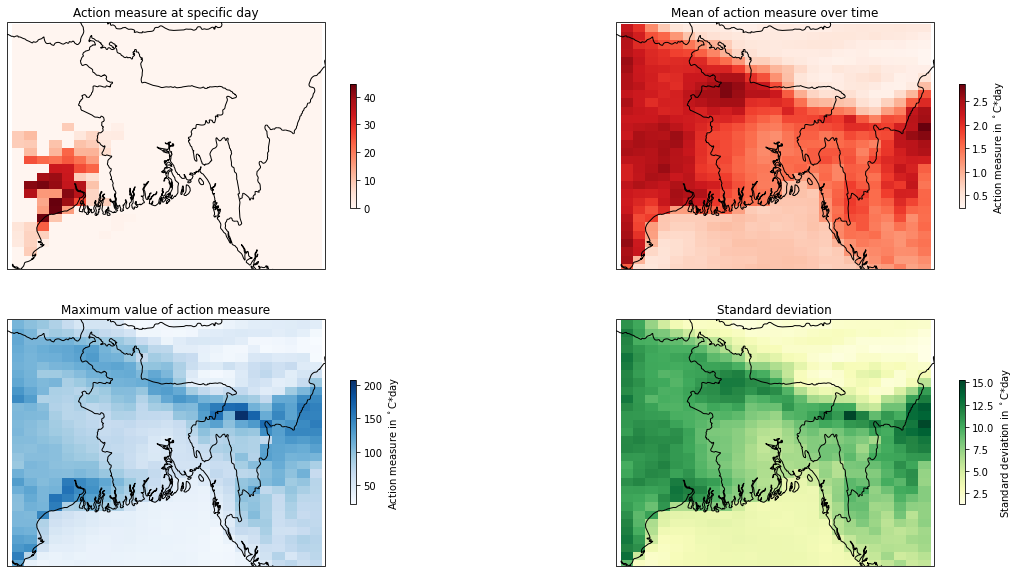

In [10]:
AM_bang_HM_had_hist = calculate_action_measures_grid(bang_had_HM_hist, bang_extent)

In [11]:
new_filename_1 = 'output/am_hist_HM_bang_HADM3.nc'
AM_bang_HM_had_hist.to_netcdf(path=new_filename_1)

### Bangladesh high-medium resolution in the future

In [15]:
bang_Had_HM_fut = xr.open_dataset('bang_Had_HM_fut.nc')

<xarray.Variable ()>
array(cftime.Datetime360Day(2020, 6, 23, 12, 0, 0, 0, has_year_zero=True),
      dtype=object)


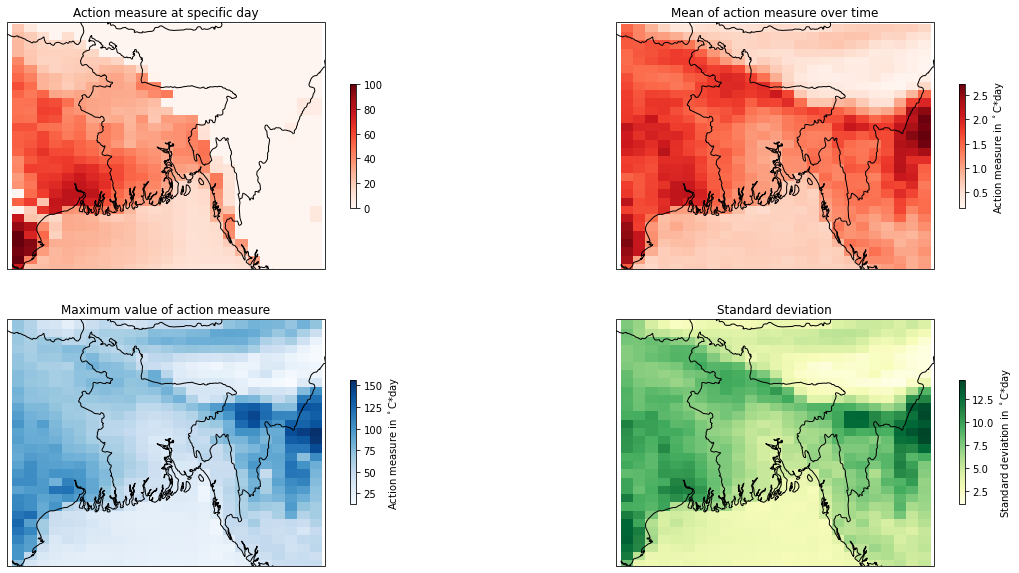

In [16]:
AM_bang_HM_had_fut = calculate_action_measures_grid(bang_Had_HM_fut, bang_extent)

In [19]:
new_filename_1 = 'output/am_fut_HM_bang_HADM3.nc'
AM_bang_HM_had_fut.to_netcdf(path=new_filename_1)

### High-medium resolution for the asia extent in the future and history

In [8]:
asia_had_HM_hist = xr.open_dataset('asia_Had_HM_hist.nc')
asia_had_HM_fut = xr.open_dataset('asia_Had_HM_fut.nc')

<xarray.Variable ()>
array(cftime.Datetime360Day(1955, 6, 23, 12, 0, 0, 0, has_year_zero=True),
      dtype=object)


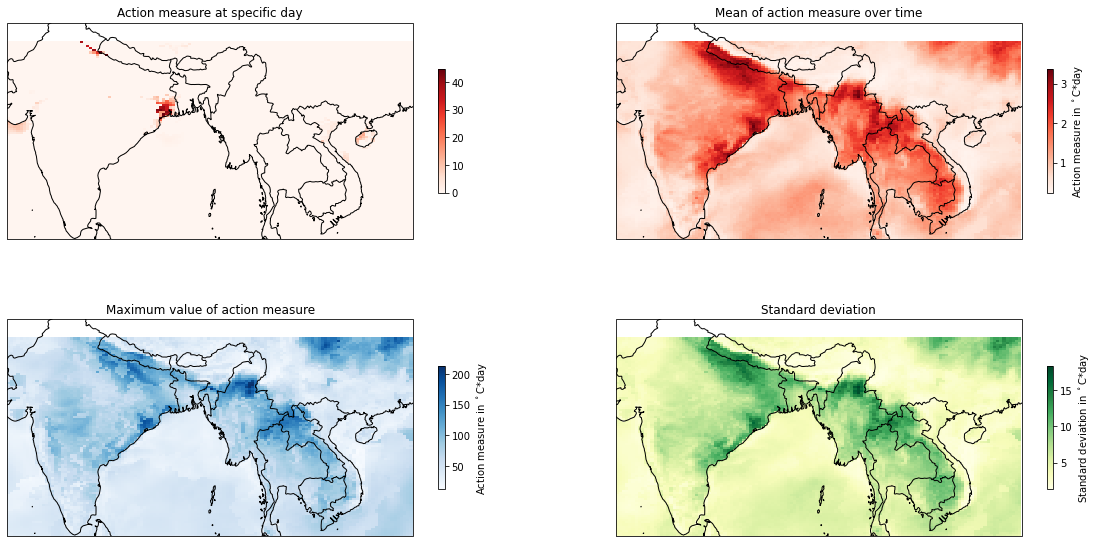

In [9]:
# history
AM_asia_HM_had_hist = calculate_action_measures_grid(asia_had_HM_hist, asia_extent)

In [10]:
new_filename_1 = 'output/am_hist_HM_asia_HADM3.nc'
AM_asia_HM_had_hist.to_netcdf(path=new_filename_1)

<xarray.Variable ()>
array(cftime.Datetime360Day(2020, 6, 23, 12, 0, 0, 0, has_year_zero=True),
      dtype=object)


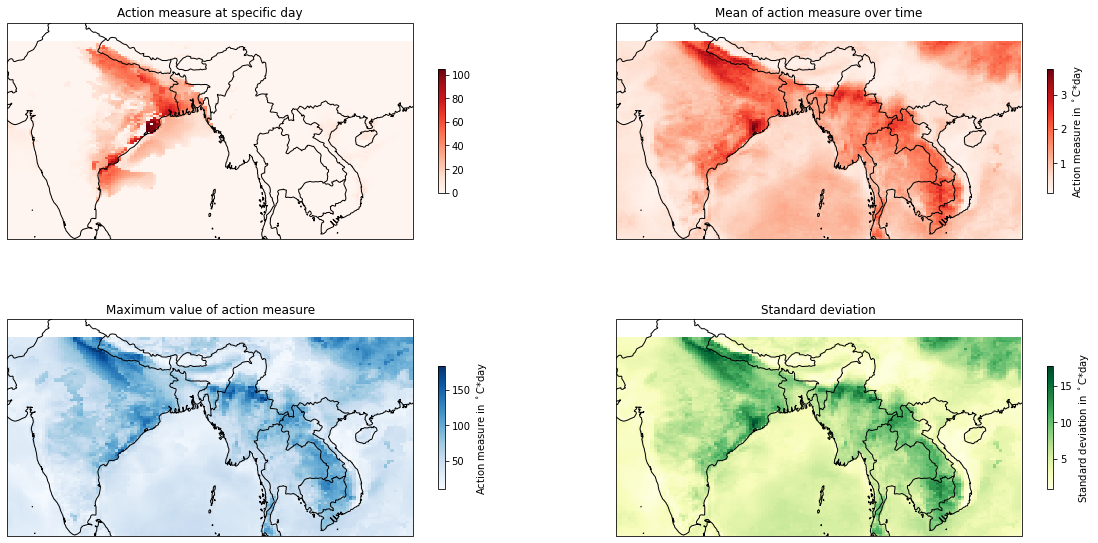

In [11]:
# future
AM_asia_HM_had_fut = calculate_action_measures_grid(asia_had_HM_fut, asia_extent)

In [18]:
new_filename_1 = 'output/am_fut_HM_asia_HADM3.nc'
AM_asia_HM_had_fut.to_netcdf(path=new_filename_1)

### Asia Medium reso

<xarray.Variable ()>
array(cftime.Datetime360Day(1855, 6, 23, 12, 0, 0, 0, has_year_zero=True),
      dtype=object)


/Users/Lisanne/opt/anaconda3/lib/python3.9/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


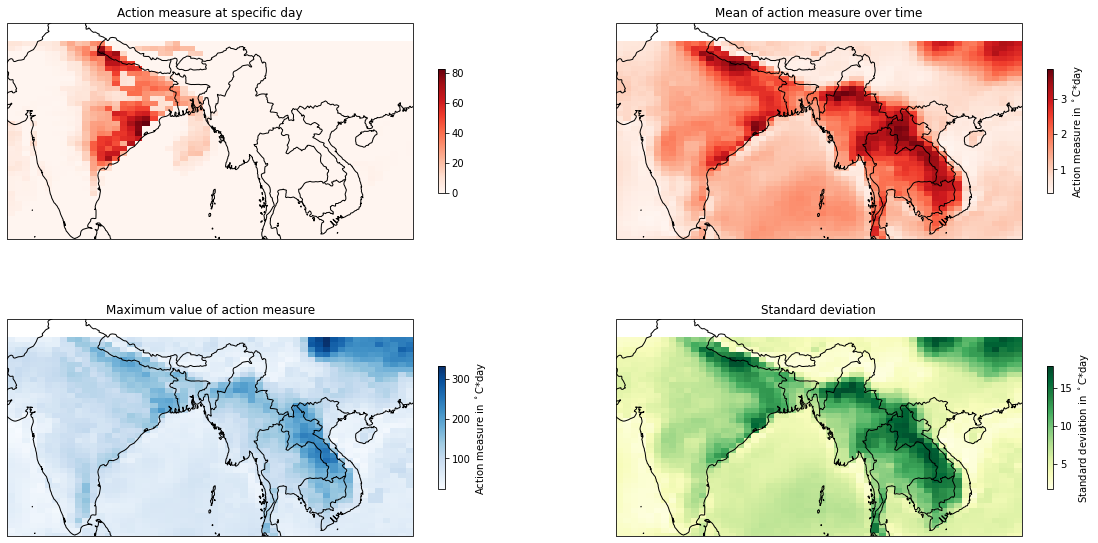

In [12]:
action_measure_datasets_asia = calculate_action_measures_grid(asia_HADM3, asia_extent)

In [13]:
new_filename_1 = 'output/am_asia_HADM3.nc'
action_measure_datasets_asia.to_netcdf(path=new_filename_1)